In [1]:
!pip install umap-learn scikit-learn numpy torch scanpy pandas scipy muon --quiet

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      running bdist_wheel
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-j5usqbkr/sklearn_2ea1528eca524b81b817ea3bd9b4e418/setup.py", line 121, in <module>
          setuptools.setup(
        File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/setuptools/__init__.py", line 155, in setup
          return distutils.core.setup(**attrs)
        File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/setuptools/_distutils/core.py", line 148, in setup
          return run_commands(dist)
        File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/setuptools/_distutils/core.py", line 163, in run_commands
          dist.run_commands()
        File "/opt/saturncloud/envs/saturn/lib/python3.9/site-p

In [2]:
import cudf
import cuml
import numpy as np
import scanpy as sc
import muon as mu
import pandas as pd
import gc
from numba import cuda
import matplotlib.pyplot as plt

from muon import atac as ac
from muon import prot as pt
from warnings import filterwarnings
filterwarnings('ignore')

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.4.4 scikit-learn==1.2.0 statsmodels==0.13.5 pynndescent==0.5.8


In [3]:
adata = sc.read_h5ad('./sc_training.h5ad')
adata

AnnData object with n_obs × n_vars = 28697 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

In [4]:
def proportions(data, ko_gene, return_n = False):
    ordering = ['progenitor','effector','terminal exhausted','cycling','other']
    counts = np.zeros(5)
    data_subset = data[data['condition'] == ko_gene]
    for i,state in enumerate(ordering):
        counts[i] = (data_subset['state'] == state).sum()
    n = len(data_subset)
    if return_n:
        return counts / n, n
    else:
        return counts / n
    

In [5]:
all_props = np.zeros((67,5))

In [6]:
genes = adata.obs['condition'].unique().tolist()
for i,g in enumerate(genes):
    all_props[i] = proportions(adata.obs,g)

In [7]:
df = pd.DataFrame(data=all_props, index=genes)

# UMAP Setup

In [8]:
from cuml import UMAP
from cuml import PCA
import cupy as cp

In [9]:
cudata = cudf.DataFrame(adata.to_df())

In [10]:
colors = ['blue','red','green','yellow','pink']
ordering = ['progenitor','effector','terminal exhausted','cycling','other']
classes = [0,1,2,3,4]

colordict = {s:c for (s,c) in zip(ordering, colors)}
classdict = {s:c for (s,c) in zip(ordering, classes)}

genecolors = [colordict[s] for s in adata.obs['state']]
classes = [classdict[s] for s in adata.obs['state']]

# Umap Fiddling

## PCA Transform

In [22]:
pca_comps = 200

pca_float = PCA(n_components = pca_comps)
pca_float.fit(cudata)
output = pca_float.transform(cudata)

## UMAP Fit and Transform 2d

In [ ]:
reducer = UMAP(n_neighbors=30,min_dist=0.3)
embedding = reducer.fit_transform(output)
embedding_big = reducer.fit_transform(cudata)

In [ ]:
embedding_big.shape

In [ ]:
plt.scatter(embedding_big[0].to_arrow().to_pylist(), embedding_big[1].to_arrow().to_pylist(), c=genecolors, s=10)
plt.title('UMAP embedding of genes');

In [ ]:
plt.scatter(embedding[0].to_arrow().to_pylist(), embedding[1].to_arrow().to_pylist(), c=genecolors, s=0.3)
plt.title('UMAP embedding of genes');

## UMAP Fit and Transform 3d

In [ ]:
reducer3d = UMAP(n_neighbors=30,min_dist=0.3, n_components=3)
gc.collect()

In [ ]:
embedding3d = reducer3d.fit_transform(output)

In [ ]:
embedding_big3d = reducer3d.fit_transform(cudata)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(embedding3d[0].to_arrow().to_pylist(), embedding3d[1].to_arrow().to_pylist(), embedding3d[2].to_arrow().to_pylist(), c=genecolors)
plt.title('UMAP embedding of genes');

# Experiment Time

### Set useful variables

In [11]:
colors = ['blue','red','green','black','pink']
ordering = ['progenitor','effector','cycling','terminal exhausted','other']
classes = [0,1,2,3,4]

colordict = {s:c for (s,c) in zip(ordering, colors)}
classdict = {s:c for (s,c) in zip(ordering, classes)}

genecolors = [colordict[s] for s in adata.obs['state']]
classes = [classdict[s] for s in adata.obs['state']]

### PCA

In [12]:
pca_comps = 100 # Number of components used in Innes's cell experiments

pca_train = PCA(n_components = pca_comps)
pca_train.fit(cudata)
output = pca_train.transform(cudata)

In [13]:
# We don't want to train on genes without perturbations

genes = adata.obs['condition'].unique().tolist()
genes.remove(genes[0])

### Data Splitting

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train, test = train_test_split(genes,train_size = 0.75, random_state = 34)

In [16]:
train_set = set(train)
test_set = set(test)

In [17]:
train_ind = [x in train_set for x in adata.obs['condition']]
train_x = output[train_ind]
train_y = cudf.DataFrame([classdict[s] for s in adata.obs['state'][train_ind]])

In [18]:
test_ind = [x in test_set for x in adata.obs['condition']]
test_x = output[test_ind]
test_y = cudf.DataFrame([classdict[s] for s in adata.obs['state'][test_ind]])

In [ ]:
cattest = [classdict[s] for s in adata.obs['state'][test_ind]]
colortest = [colordict[s] for s in adata.obs['state'][test_ind]]

colortrain = [colordict[s] for s in adata.obs['state'][train_ind]]
cattrain = np.array([classdict[s] for s in adata.obs['state'][train_ind]])

### Embed and Plot

In [72]:
reducer = UMAP(n_neighbors=30, min_dist=0.1)

In [73]:
reducer.fit(train_x,train_y, )

UMAP()

In [74]:
y_train_est = reducer.transform(train_x)

In [75]:
y_est = reducer.transform(test_x)

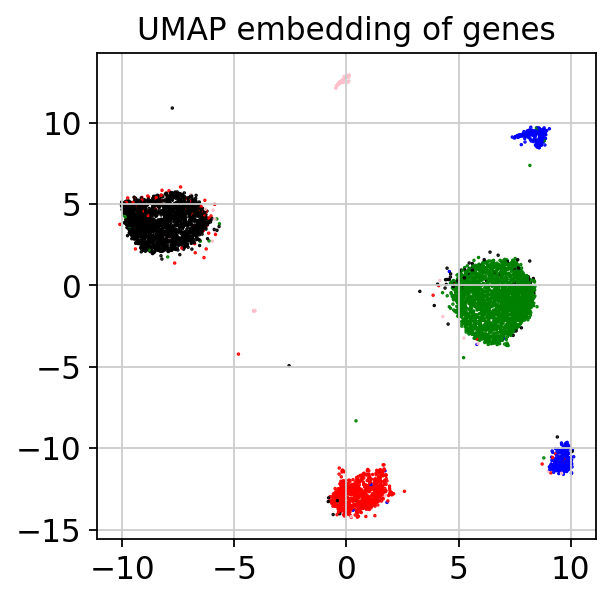

In [76]:
plt.scatter(y_est[0].to_arrow().to_pylist(), y_est[1].to_arrow().to_pylist(), c=colortest, s=0.3)
plt.title('UMAP embedding of genes');

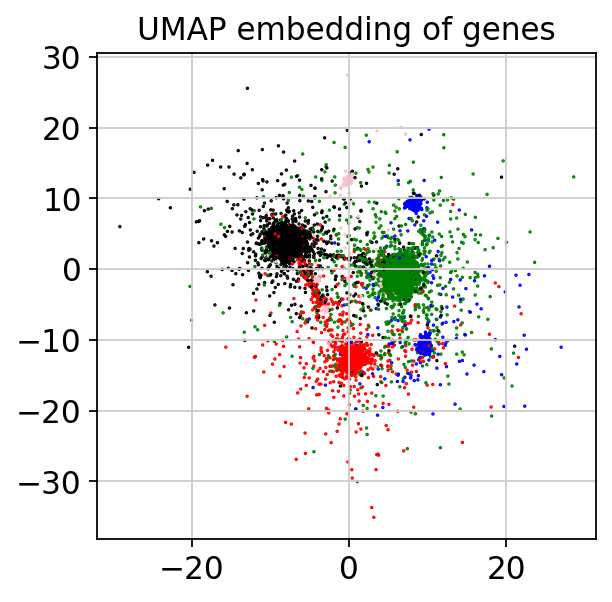

In [78]:
plt.scatter(y_train_est[0].to_arrow().to_pylist(), y_train_est[1].to_arrow().to_pylist(), c=colortrain, s=0.3)
plt.title('UMAP embedding of genes');

# Map Clusters

In [79]:
from cuml import HDBSCAN, KMeans, DBSCAN
import torch

In [80]:
kmeans = KMeans(n_clusters = 6)
cats_kmeans = kmeans.fit_predict(y_est)

In [81]:
kmeans.cluster_centers_

,0,1
0,9.614120,-10.740916
1,-8.175039,3.861001
2,0.540922,-12.776045
3,8.357363,9.196842
4,6.748386,-0.843992
5,-0.145630,12.599799


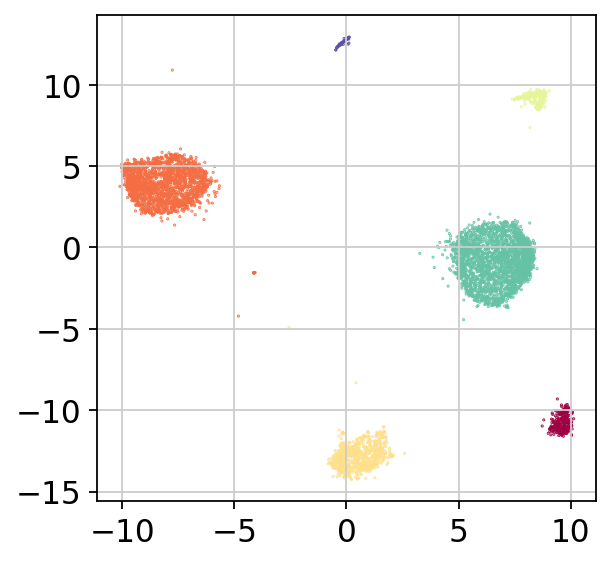

In [82]:
plt.scatter(y_est[0].to_arrow().to_pylist(), 
            y_est[1].to_arrow().to_pylist(),
            c=kmeans.labels_.to_numpy(),
            s=0.13,
            cmap='Spectral');

### HDBSCAN clustering

In [140]:
hdbscan.labels_.unique()

0   -1
1    0
2    1
3    2
4    3
5    4
dtype: int32

In [136]:
hdbscan = HDBSCAN(min_samples=10,
    min_cluster_size=100,)
cats_hdb = hdbscan.fit_predict(y_est)

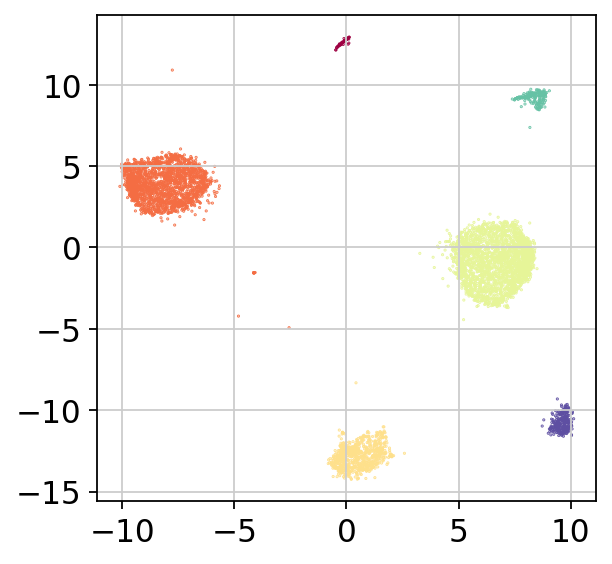

In [137]:
plt.scatter(y_est[0].to_arrow().to_pylist(), 
            y_est[1].to_arrow().to_pylist(),
            c=hdbscan.labels_.to_numpy(),
            s=0.13,
            cmap='Spectral');

### DBSCAN Clustering

In [172]:
dbscan = DBSCAN()
cats_db = dbscan.fit_predict(y_est)
clustered = [c >= 0 for c in cats_db.to_numpy()]
y_est_dn = y_est[clustered]
y_est_labels = dbscan.labels_[clustered].to_numpy()

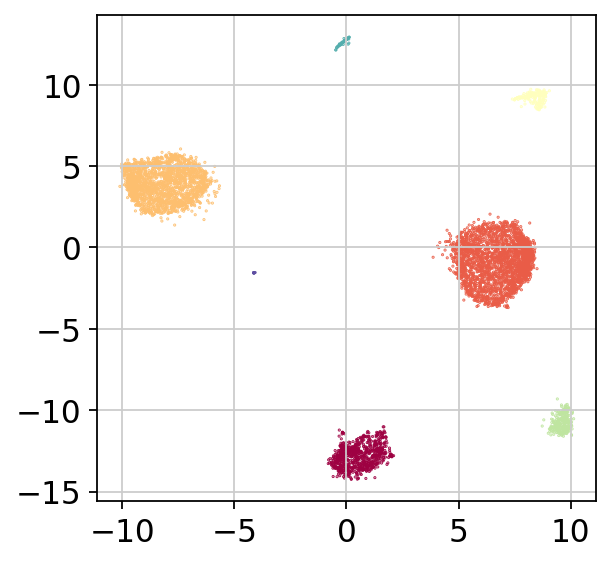

In [173]:
plt.scatter(y_est[0][clustered].to_arrow().to_pylist(), 
            y_est[1][clustered].to_arrow().to_pylist(),
            c=dbscan.labels_[clustered].to_numpy(),
            s=0.13,
            cmap='Spectral');

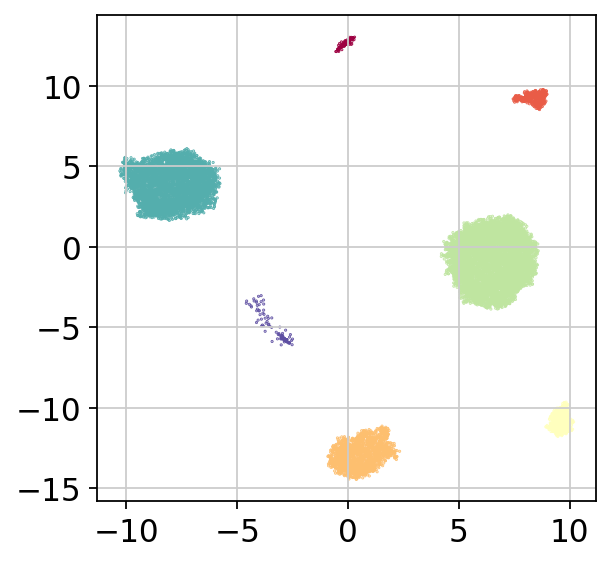

In [177]:
hdbscan = HDBSCAN(min_samples=10,
    min_cluster_size=100,)

hdbscan.fit_predict(y_train_est)

clustered = [p > 0.5 for p in hdbscan.probabilities_.to_numpy()]

ytr_dn = y_train_est[clustered]
ytr_labels = hdbscan.labels_[clustered].to_numpy()

plt.scatter(ytr_dn[0].to_numpy(), 
            ytr_dn[1].to_numpy(),
            c=ytr_labels,
            s=0.13,
            cmap='Spectral');

n_clusters = np.unique(hdbscan.labels_[clustered].to_numpy())

In [201]:
dists = c1toc2(ytr_dn.to_numpy(),ytr_labels,y_est_dn.to_numpy(), y_est_labels)
dists = sorted(dists, key=lambda x: x[0][0])
# This is finnicky
dists = list(filter(lambda d: d[1] < 2, dists))
c1_order = [d[0][0] for d in dists]
c2_order = [d[0][1] for d in dists]

p1 = proportions_clusters(data_subset = ytr_labels, ordering = c1_order)
p2 = proportions_clusters(data_subset = y_est_labels, ordering = c2_order)

In [205]:
p1, p2

(array([0.00933262, 0.03095206, 0.12837384, 0.04438029, 0.46313952,
        0.31522761]),
 array([0.00922604, 0.03280369, 0.14129506, 0.0468136 , 0.43943277,
        0.32889117]))

In [125]:
def get_centroid(posns):
    return np.sum(posns, axis=0)/len(posns)

In [185]:
def c1toc2(coords1, clust1, coords2, clust2):
    cents1 = {}
    for c in np.unique(clust1):
        c_coords = coords1[clust1 == c]
        cents1[c] = get_centroid(c_coords)
        
    cents2 = {}
    for c in np.unique(clust2):
        c_coords = coords2[clust2 == c]
        cents2[c] = get_centroid(c_coords)
    pairs = []
    for c1 in cents1:
        mindist = 10000
        pair = (0,0)
        for c2 in cents2:
            dist = np.sum(np.square(cents1[c1] - cents2[c2]))
            if dist < mindist:
                mindist = dist
                pair = (c1,c2)
        pairs.append((pair,mindist))
    return pairs

In [38]:
def xentropy(p,q):
    return -np.sum(p*np.log(q))

In [39]:
def EMD(p, q):
    return np.abs(p-q).sum()

In [199]:
def proportions_clusters(data_subset, ordering, return_n = False):
    counts = np.zeros(len(ordering))
    for i,state in enumerate(ordering):
        counts[i] = (data_subset == state).sum()
    n = len(data_subset)
    if return_n:
        return counts / n, n
    else:
        return counts / n

In [86]:
p = proportions_clusters(pd.Series(cattest))
q1 = proportions_clusters(cats_kmeans)
q2 = proportions_clusters(cats_hdb)
q3 = proportions_clusters(cats_db)